In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display import HTML, display
from collections import defaultdict
from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer,StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline


sns.set_palette(sns.color_palette("RdBu_r", 7))

![](1.png)

### Utilidades

In [3]:
def evaluate_model(model, set_names=('data_train', 'data_test'), title='', show_cm=True):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['data_train', 'data_test','data_validation']
        set_data = globals()[set_name] # <- hack feo...

        y = set_data.fake
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['Genuina', 'Falsa'])
            ax.yaxis.set_ticklabels(['Genuina', 'Falsa'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### Extracción del DataSet

In [4]:
path_train="train.csv"
path_test="test.csv"

test = pd.read_csv(path_test)
train = pd.read_csv(path_train) 
full = pd.concat([train, test], sort=False)

renamed_columns = {
        'profile pic': 'profile_pic', 'nums/length username': 'nums_div_length_username',
        'fullname words': 'fullname_words','nums/length fullname': 'nums_div_length_fullname',
        'name==username': 'name__username','description length': 'description_length',
        'external URL': 'external_url','private':'private','#posts':'posts',
        '#followers':'followers','#follows':'follows','fake':'fake'
}
test.rename(columns=renamed_columns, inplace=True)
train.rename(columns=renamed_columns, inplace=True)
full.rename(columns=renamed_columns, inplace=True)

## Armado de Datasets

In [5]:
data_train, not_train = train_test_split(full, test_size=0.4, random_state=42)
data_validation, data_test = train_test_split(not_train, test_size=0.5, random_state=42)

## Metrica Utilizada
* Precision: elegimos esta metrica ya que nos interesa estar seguros al momento de decir si una cuenta es falsa para posteriormente bloquearla. De esta manera reducimos el riesgo de bloquear erroneamente una cuenta que no es falsa.


## Metricas NO Utilizadas
* Accuracy: esta metrica no se adapta al problema porque el errar diciendo "es falsa" es mas costoso ya que bloqueariamos cuentas que no son falsas.
* Recall: esta metrica es util cuando no queres que se escape ningun caso de "es falsa" con el costo de que vas a decir "es falsa" cuando no lo es en algunos casos. Lo que seria un problema ya que en esos casos vamos a bloquear cuentas que no son falsas.

In [6]:
data_train.sample(10)

profile_pic  nums_div_length_username  fullname_words  \
147            1                      0.36               5   
547            0                      0.57               1   
8              1                      0.00               0   
109            1                      0.44               1   
303            0                      0.18               1   
553            0                      0.73               1   
117            1                      0.00               2   
57             1                      0.14               2   
85             1                      0.00               3   
413            0                      0.15               2   

     nums_div_length_fullname  name__username  description_length  \
147                      0.00               0                  71   
547                      0.57               1                   0   
8                        0.00               0                  71   
109                      0.00               0                   0   
303                      0.00               0                   0   
553                      0.00               0                   0   
117                      0.00               0                   0   
57                       0.00               0                   0   
85                       0.00               0                  21   
413                      0.00               0                   0   

     external_url  private  posts  followers  follows  fake  
147             0        0      8        216      305     0  
547             0        0      2         34      112     1  
8               0        0     72       1824     2713     0  
109             0        0     60        238     1381     1  
303             0        1      0          5       10     1  
553             0        0      0         14      542     1  
117             0        0      3        833     3572     1  
57              0        0      9        209      276     0  
85              1        0     40        824      489     0  
413             0        0      1         13       22     1

## Feature Engineering
Consideramos que para las siguientes features **NO** es necesario realizar un preprocesado ya que son 0|1:
    * procfile_pic
    * name__username
    * description_length
    * external_url
    * private
    
Estandarizamos las siguientes features:
    * nums_div_length_username
    * fullname_words
    * nums_div_length_fullname
    * description_length

Realizamos Binning a la siguientes features con el objetivo de evitar el overfitting:
    * posts
    * followers
    * follows

In [7]:
mapper = DataFrameMapper([
    (['profile_pic'],None),
    (['nums_div_length_username'],[StandardScaler()]),
    (['fullname_words'],[StandardScaler()]),
    (['nums_div_length_fullname'],[StandardScaler()]),
    (['name__username'],None),
    (['description_length'],[StandardScaler()]),
    (['external_url'],None),
    (['private'],None),
    (['posts'], [ KBinsDiscretizer(encode='ordinal',strategy='quantile',n_bins=2) ]),
    (['followers'], [KBinsDiscretizer(encode='ordinal',strategy='quantile')]),
    (['follows'], [ KBinsDiscretizer(encode='ordinal',strategy='quantile')]),
])


In [8]:
mapper.fit(data_train)
mapper.transform(data_train)

array([[ 1.        , -0.80045402, -1.35543961, ...,  1.        ,
         3.        ,  2.        ],
       [ 1.        , -0.80045402, -0.44964103, ...,  1.        ,
         3.        ,  4.        ],
       [ 1.        , -0.80045402,  0.45615756, ...,  0.        ,
         2.        ,  2.        ],
       ...,
       [ 1.        , -0.80045402,  1.36195615, ...,  1.        ,
         3.        ,  4.        ],
       [ 1.        , -0.80045402,  1.36195615, ...,  1.        ,
         2.        ,  2.        ],
       [ 1.        , -0.80045402,  1.36195615, ...,  1.        ,
         3.        ,  2.        ]])

## Regresion Logistica

Accuracy  Precision    Recall        F1
data_train  0.940048   0.956938  0.925926  0.941176
data_test   0.928571   0.967213  0.880597  0.921875

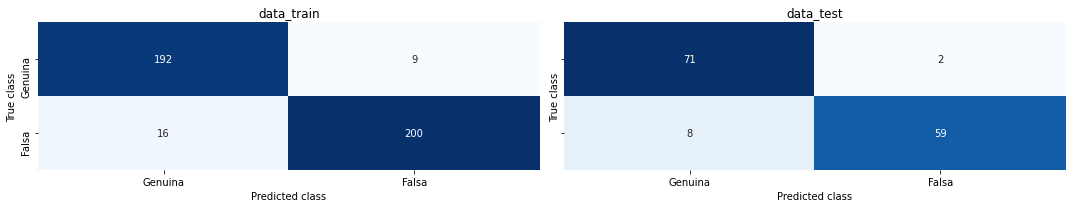

In [9]:
lr_model = Pipeline([
    ('mapper', mapper),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(random_state=42)),
])

lr_model.fit(data_train, data_train.fake)

evaluate_model(lr_model)

### Peso de las variables

array([[-2.40267657,  0.97363592, -0.20910913,  0.37494309,  0.38253025,
        -0.48297836, -0.99900054, -1.47173509, -1.17092065, -1.67726802,
         0.58618733]])

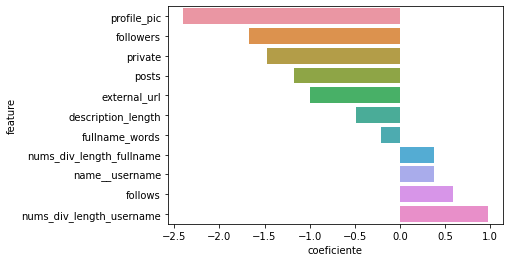

In [10]:
clf = lr_model.named_steps['classifier']
display(clf.coef_)

names = mapper.transformed_names_
df_importance = pd.DataFrame({'feature': names, 'coeficiente': clf.coef_[0]}).sort_values(by='coeficiente')
ax = sns.barplot(x='coeficiente', y='feature', data=df_importance)

 **Conclusión:** Podemos observar que este modelo funciona correctamente ya que tanto en train como en test la metrica da resultados positivos. Podriamos suponer que los datos siguen una tendencia lineal.

### Regresion Logistica con Features polinomicas

Accuracy  Precision    Recall        F1
data_train  0.966427   0.971963  0.962963  0.967442
data_test   0.878571   0.878788  0.865672  0.872180

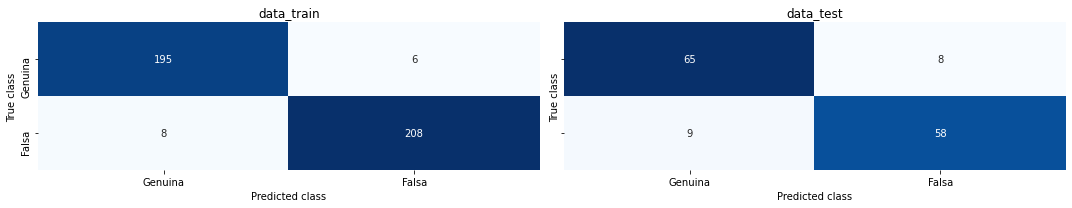

In [11]:
lr_model_fp = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', LogisticRegression(max_iter=3000, random_state=42)),
])

lr_model_fp.fit(data_train,data_train.fake)
evaluate_model(lr_model_fp)

 **Conclusión:** Podemos observar que agregar Features Polynomial no es favorable para este modelo, ya que obtenemos mejores resultados en train pero en test caen. Esto nos lleva a pensar que el modelo esta sobreentrenando.

## K nearest neighbors

Realizamos varios experimientos con K (5,10,15,20) y alternando con o sin Features Polynomial.

'Knn K: 5'

Accuracy  Precision    Recall        F1
data_train  0.949640   0.962085  0.939815  0.950820
data_test   0.885714   0.904762  0.850746  0.876923

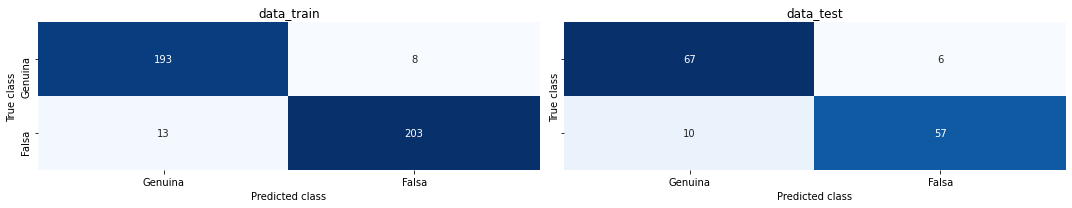

'Knn-PL K: 5'

Accuracy  Precision    Recall        F1
data_train  0.954436   0.962441  0.949074  0.955711
data_test   0.885714   0.918033  0.835821  0.875000

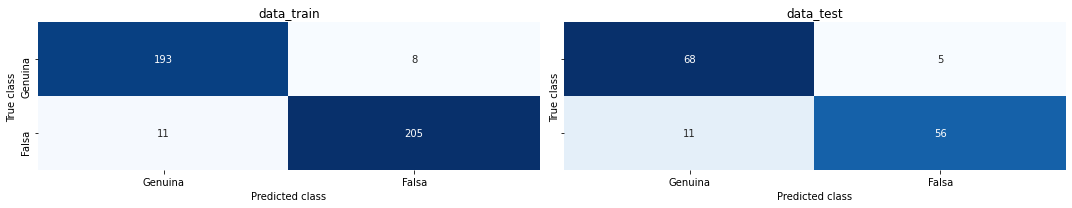

'Knn K: 10'

Accuracy  Precision    Recall        F1
data_train  0.942446   0.970588  0.916667  0.942857
data_test   0.914286   0.936508  0.880597  0.907692

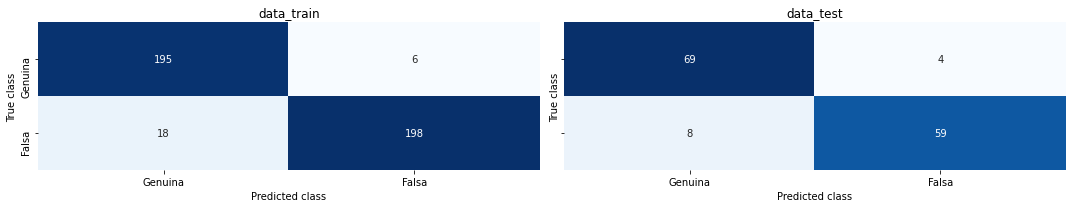

'Knn-PL K: 10'

Accuracy  Precision    Recall        F1
data_train  0.937650   0.952381  0.925926  0.938967
data_test   0.892857   0.933333  0.835821  0.881890

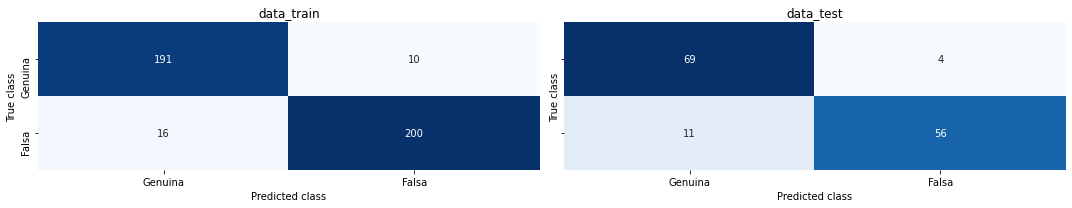

'Knn K: 15'

Accuracy  Precision    Recall        F1
data_train  0.932854   0.947619  0.921296  0.934272
data_test   0.921429   0.951613  0.880597  0.914729

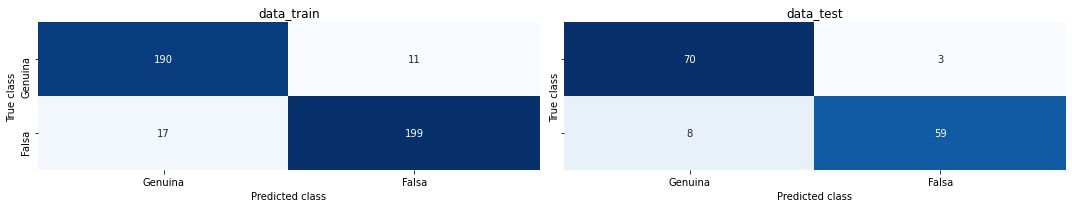

'Knn-PL K: 15'

Accuracy  Precision    Recall        F1
data_train  0.928058   0.934579  0.925926  0.930233
data_test   0.921429   0.937500  0.895522  0.916031

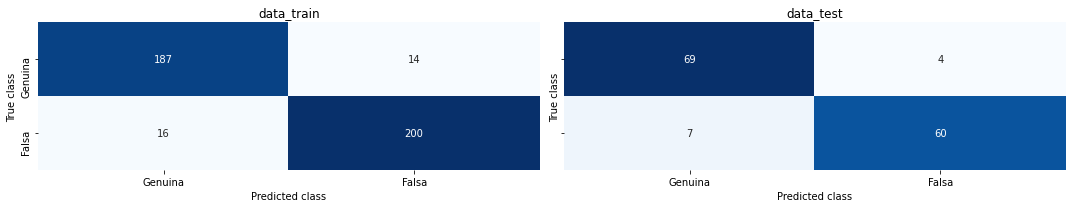

'Knn K: 20'

Accuracy  Precision    Recall       F1
data_train  0.923261   0.950980  0.898148  0.92381
data_test   0.892857   0.933333  0.835821  0.88189

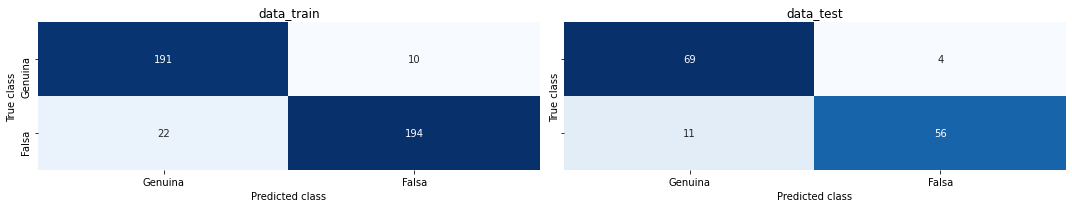

'Knn-PL K: 20'

Accuracy  Precision    Recall       F1
data_train  0.918465   0.925234  0.916667  0.92093
data_test   0.892857   0.933333  0.835821  0.88189

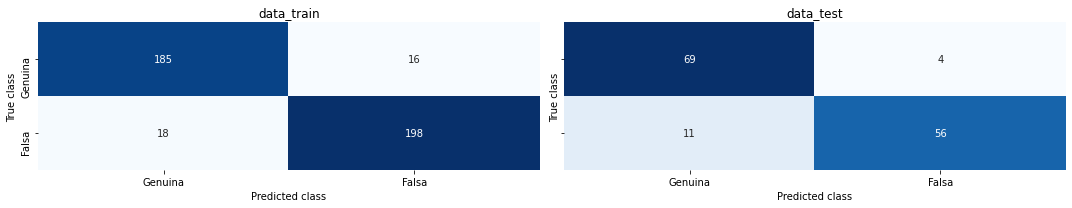

In [12]:
for k in (5,10,15,20):
    knn_model = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=42)),
        ('classifier', KNeighborsClassifier(n_neighbors=k)),
    ])
    

    knn_model.fit(data_train,data_train.fake)
    titulo = 'Knn K: ' + str(k)
    evaluate_model(knn_model, title=titulo)
    
    knn_model_fp = Pipeline([
        ('mapper', mapper),
        ('imputer', IterativeImputer(random_state=42)),
        ('poli', PolynomialFeatures(degree=2)),
        ('classifier', KNeighborsClassifier(n_neighbors=k)),
    ])
    knn_model_fp.fit(data_train,data_train.fake)
    titulo = 'Knn-PL K: ' + str(k)
    evaluate_model(knn_model_fp, title=titulo)
    

'Knn K: 15'

Accuracy  Precision    Recall        F1
data_train  0.932854   0.947619  0.921296  0.934272
data_test   0.921429   0.951613  0.880597  0.914729

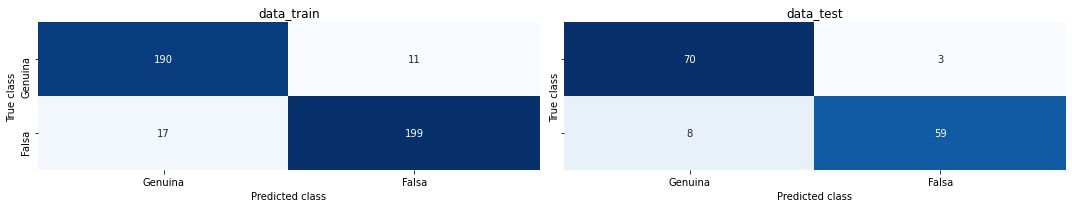

In [22]:
knn_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=15)),
])


knn_model.fit(data_train,data_train.fake)
titulo = 'Knn K: 15'
evaluate_model(knn_model, title=titulo)

**Conclusión:** Podemos observar que los mejores resultados los obtenemos con K=15 y sin Features Polynomial.

## Arboles de decisión

Realizamos varios experimientos con profundidad de 3 a 6 y alternando con o sin Features Polynomial.

'Decision Tree- max_depth: 3'

Accuracy  Precision    Recall        F1
data_train  0.937650   0.939815  0.939815  0.939815
data_test   0.892857   0.919355  0.850746  0.883721

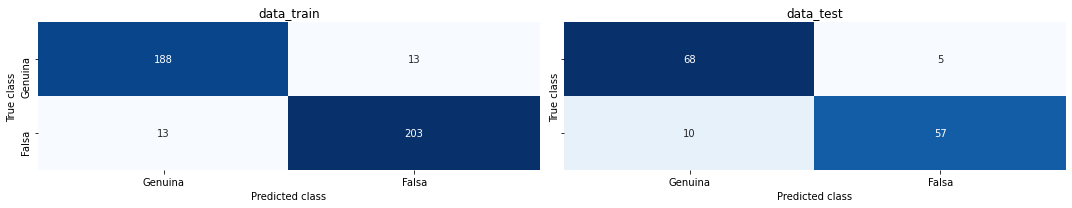

'Decision Tree PL- max_depth: 3'

Accuracy  Precision    Recall        F1
data_train  0.947242   0.966346  0.930556  0.948113
data_test   0.900000   0.934426  0.850746  0.890625

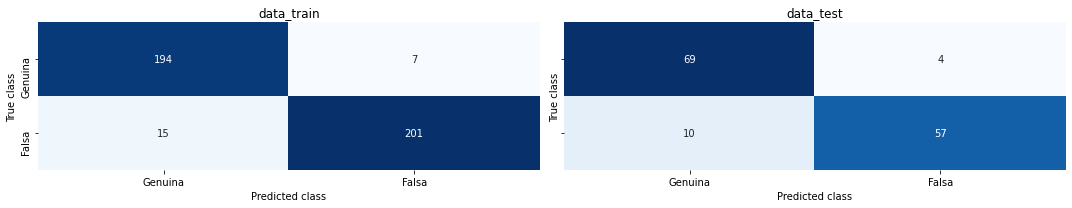

'Decision Tree- max_depth: 4'

Accuracy  Precision    Recall        F1
data_train  0.942446   0.961538  0.925926  0.943396
data_test   0.892857   0.919355  0.850746  0.883721

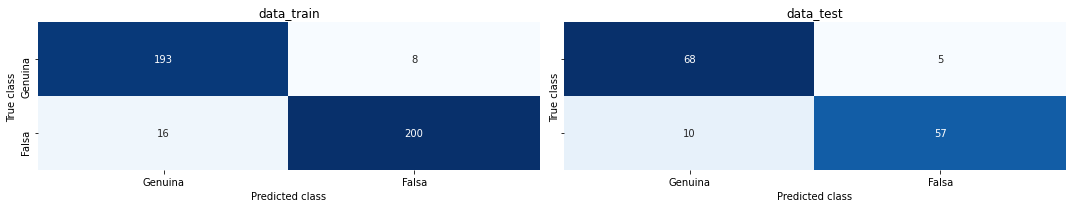

'Decision Tree PL- max_depth: 4'

Accuracy  Precision    Recall        F1
data_train  0.961631   0.985437  0.939815  0.962085
data_test   0.900000   0.934426  0.850746  0.890625

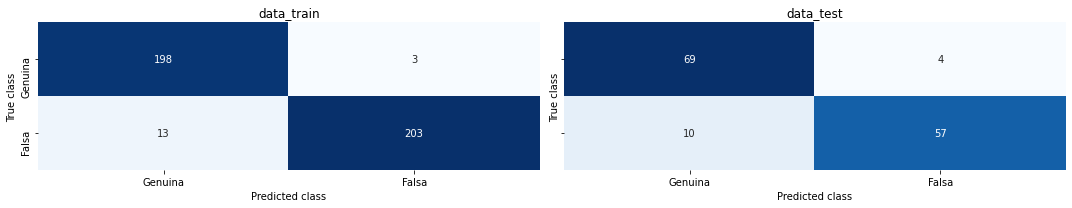

'Decision Tree- max_depth: 5'

Accuracy  Precision    Recall        F1
data_train  0.966427   0.980952  0.953704  0.967136
data_test   0.892857   0.906250  0.865672  0.885496

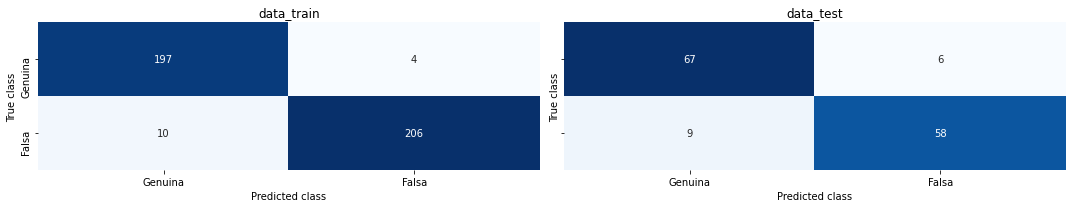

'Decision Tree PL- max_depth: 5'

Accuracy  Precision    Recall        F1
data_train  0.976019   0.990476  0.962963  0.976526
data_test   0.885714   0.918033  0.835821  0.875000

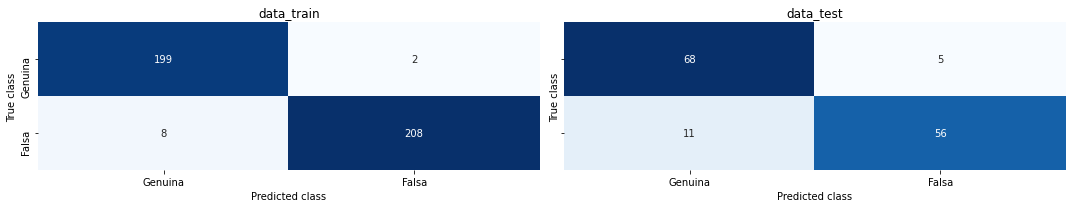

'Decision Tree- max_depth: 6'

Accuracy  Precision    Recall        F1
data_train  0.976019   0.981308  0.972222  0.976744
data_test   0.892857   0.906250  0.865672  0.885496

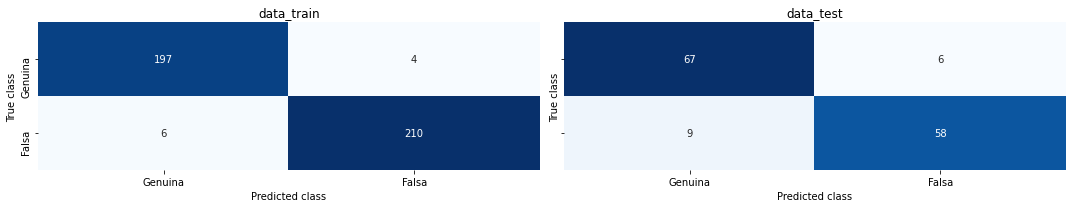

'Decision Tree PL- max_depth: 6'

Accuracy  Precision    Recall        F1
data_train  0.985612   0.995283  0.976852  0.985981
data_test   0.857143   0.861538  0.835821  0.848485

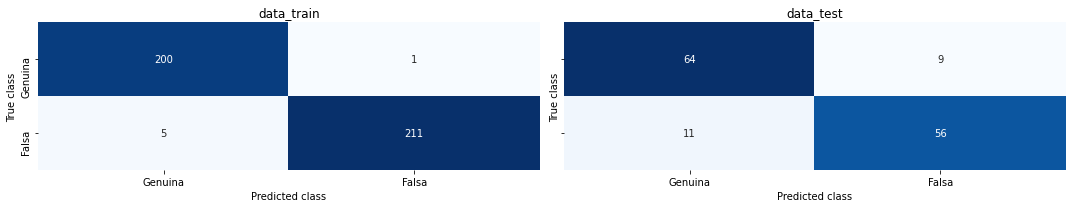

In [13]:
for p_max in (3,4,5,6):
    tree_model = DecisionTreeClassifier(random_state=42,max_depth=p_max)

    dt_model = Pipeline([
        ('mapper',mapper),
        ('imputer', IterativeImputer(random_state=42)),
        ('classifier', tree_model),
    ])

    dt_model.fit(data_train, data_train.fake)
    titulo = 'Decision Tree- max_depth: ' + str(p_max) 
    evaluate_model(dt_model, title=titulo)
    
    dt_model_fp = Pipeline([
        ('mapper',mapper),
        ('imputer', IterativeImputer(random_state=42)),
        ('poli', PolynomialFeatures(degree=2)),
        ('classifier', tree_model),
    ])

    dt_model_fp.fit(data_train, data_train.fake)
    titulo = 'Decision Tree PL- max_depth: ' + str(p_max) 
    evaluate_model(dt_model_fp, title=titulo)

'Decision Tree PL- max_depth: 3'

Accuracy  Precision    Recall        F1
data_train  0.947242   0.966346  0.930556  0.948113
data_test   0.900000   0.934426  0.850746  0.890625

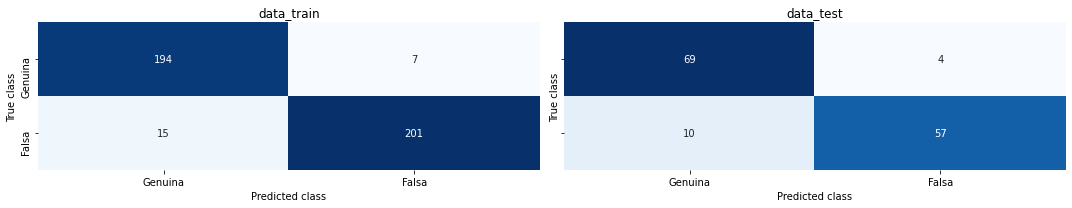

In [14]:
tree_model = DecisionTreeClassifier(random_state=42,max_depth=3)

dt_model_fp = Pipeline([
    ('mapper',mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', tree_model),
])

dt_model_fp.fit(data_train, data_train.fake)
titulo = 'Decision Tree PL- max_depth: 3' 
evaluate_model(dt_model_fp, title=titulo)

**Conclusión:** Podemos observar que la mejor opcion es con Features Polynomial y una profundidad de 3.

## Random Forest

In [15]:
forest_model = RandomForestClassifier(random_state=42)
parameters = {'n_estimators': [100, 200], 
              'max_depth':[3,4, 5, 6,8],
              'max_features': [2, 5]}


clf = GridSearchCV(forest_model, parameters, refit=True, verbose=1)

cv_pipe = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', clf),
])

cv_pipe.fit(data_train,data_train.fake)
clf.best_score_, clf.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.0s finished


(0.932903040734366, {'max_depth': 8, 'max_features': 2, 'n_estimators': 200})

'Random Forest after Cross Validation'

Accuracy  Precision    Recall        F1
data_train  0.985612   0.995283  0.976852  0.985981
data_test   0.928571   0.952381  0.895522  0.923077

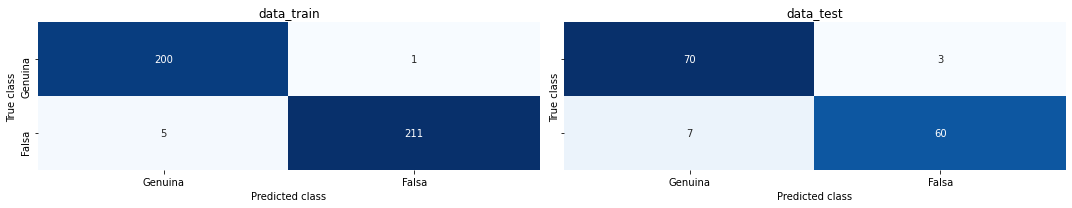

In [16]:
evaluate_model(cv_pipe, title='Random Forest after Cross Validation')

### Random Forest con Features Polynomial

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.1s finished


'Random Forest after Cross Validation FP'

Accuracy  Precision    Recall        F1
data_train  0.959233   0.962791  0.958333  0.960557
data_test   0.914286   0.936508  0.880597  0.907692

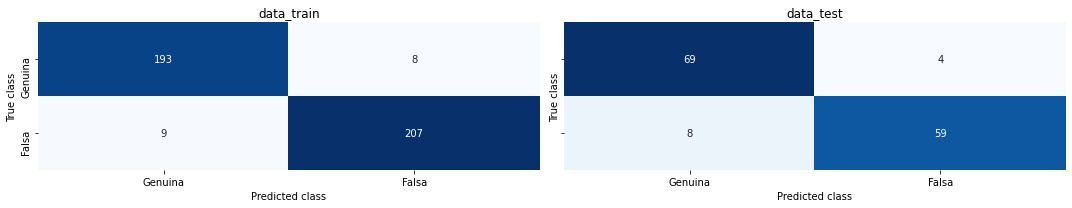

In [17]:
cv_pipe_fp = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', clf),
])

cv_pipe_fp.fit(data_train,data_train.fake)

evaluate_model(cv_pipe_fp, title='Random Forest after Cross Validation FP')


**Conclusión:** Podemos observar que obtenemos los mejores resultados sin utilizar Features Polynomial y con los parametros nombrados en la celda anterior.

## Gradient Boosted Trees

'Gradient Boosting'

Accuracy  Precision    Recall        F1
data_train  0.985612   0.990654  0.981481  0.986047
data_test   0.900000   0.920635  0.865672  0.892308

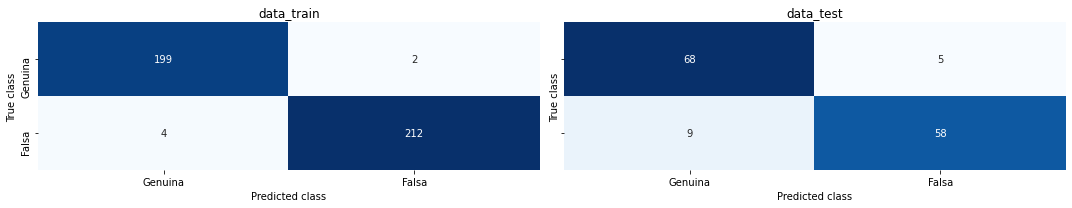

In [18]:
boost_model = GradientBoostingClassifier(random_state=42)

boo_model = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

boo_model.fit(data_train,data_train.fake)

evaluate_model(boo_model, title='Gradient Boosting')

## Gradient Boosted Trees con Features Polynomial

'Gradient Boosting FP'

Accuracy  Precision    Recall        F1
data_train  0.997602   1.000000  0.995370  0.997680
data_test   0.878571   0.890625  0.850746  0.870229

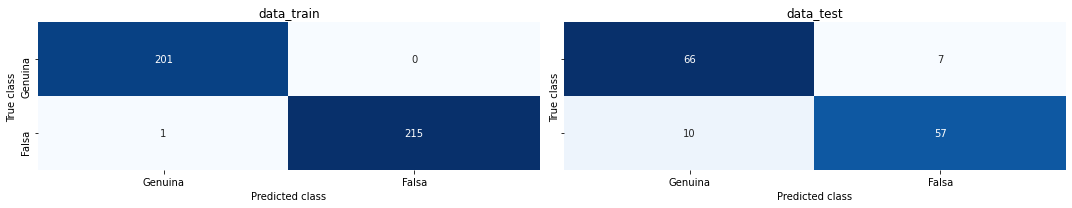

In [19]:
boo_model_fp = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('poli', PolynomialFeatures(degree=2)),
    ('classifier', boost_model),
])

boo_model_fp.fit(data_train,data_train.fake)

evaluate_model(boo_model_fp, title='Gradient Boosting FP')

**Conclusión:** Podemos observar que los mejores resultados los obtenemos sin utilizar Features Polynomial. Ya que utilizandolo obtenemos valores muy altos en train y bajos en test, por lo tanto podriamos pensar que el modelo esta sobreentrenando.

## Técnica seleciconada para evitar el sobreentrenamiento.
Desidimos utilizar la matriz de confucion con el fin de evitar el sobreentrenamiento asi podemos ir comparando mejor los resultados obtenidos en cada modelo.

## Conclusión Final


Luego de analizar diferentes modelos llegamos a la conclusion que el modelo de Regresion Logistica es el que mejor resultado nos brinda llegando a un 0.967213 en la metrica precision.

Al cliente le informariamos que nuestro modelo va a acertar en un 95% de las decisiones que tome porque ese es el valor que obtenemos en el dataset de validación.

Accuracy  Precision    Recall        F1
data_train       0.940048   0.956938  0.925926  0.941176
data_test        0.928571   0.967213  0.880597  0.921875
data_validation  0.935252   0.951613  0.907692  0.929134

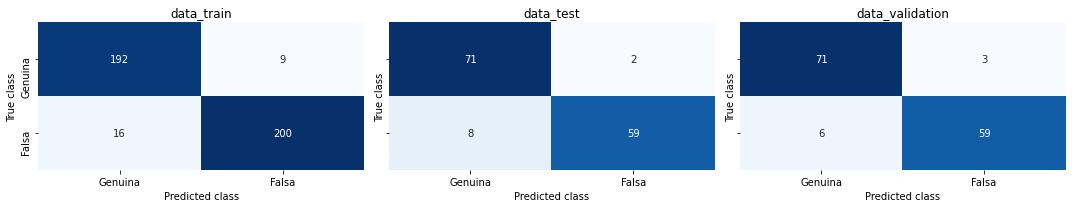

In [20]:
evaluate_model(lr_model,set_names=('data_train','data_test','data_validation'))